In [24]:
import class_function as cf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
data = pd.read_csv('../Data/result_5_merged.csv')
X = data.drop(columns=['TARGET'])
Y = data.TARGET

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [30]:
y_train.value_counts()

0    226038
1     19970
Name: TARGET, dtype: int64

In [31]:
226038/19970

11.318878317476214

In [3]:
class Multi_XGB(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        pass
    
    def train(self, x_train, y_train):
        data = pd.concat([x_train, y_train], axis=1)
        group_result = data.groupby(y_train.name)
        data_0 = group_result.get_group(0)
        data_1 = group_result.get_group(1)
        #0比1多
        im_dergee = int(data_0.shape[0]/data_1.shape[0])
        self.im_dergee = im_dergee
        data_list = []
        maj_number = data_0.shape[0]
        balanced_number = data_1.shape[0]
        for i in range(im_dergee):
            if i < im_dergee - 1:
                data_list.append(data_0.iloc[i*balanced_number:(i+1)*balanced_number, :])
            else:
                data_list.append(data_0.iloc[i*balanced_number:, :])
        
        #print(data_list[0])
                
        xgb_cla_list = []
        for i in range(im_dergee):
            x_y = pd.concat([data_list[i], data_1], axis=0)
            #print(x_y)
            x_train_ = x_y.iloc[:, :x_y.shape[1]-1]
            y_train_ = x_y.iloc[:, x_y.shape[1]-1]
            #print(y_train_)
            xgb_cla_list.append(xgb.XGBClassifier(**self.kwargs))
            xgb_cla_list[i].fit(x_train_, y_train_)
            print('*' * 40)
            print(xgb_cla_list[i].classes_)
        
        self.xgb_cla_list = xgb_cla_list
        
    def predict(self, x_test, threshold):
        xgb_cla_list = self.xgb_cla_list
        predict_proba_list = []
        for i in range(self.im_dergee):
            predict_proba = xgb_cla_list[i].predict_proba(x_test)
            predict_proba_1 = []
            for j in range(len(predict_proba)):
                predict_proba_1.append(predict_proba[j][1])
                
            predict_proba_list.append(predict_proba_1)
            
        predict_proba = []
        result = []
        for i in range(len(predict_proba_list[0])):
            tmp = 0
            for j in range(len(predict_proba_list)):
                tmp += predict_proba_list[j][i]
            
            proba = tmp / self.im_dergee
            predict_proba.append(proba)
            if proba > threshold:
                result.append(1)
            else:
                result.append(0)
        
        self.predict_proba = predict_proba
        self.result = result
        

In [4]:
multi_xgb = Multi_XGB(max_depth=10, n_estimators=500, random_state=0)
multi_xgb.train(x_train, y_train)

****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]


In [5]:
multi_xgb.predict(x_test, 0.6)
multi_xgb.result[:5]

[0, 0, 1, 0, 0]

In [6]:
multi_xgb.predict_proba

[0.23315610059282996,
 0.5936680070378564,
 0.649212428114631,
 0.1302658167075027,
 0.13747033950957385,
 0.4241094778884541,
 0.3964287286454981,
 0.7058052122592926,
 0.8023359423333948,
 0.5193733762611042,
 0.08332737746902487,
 0.7170149927789514,
 0.16169961169362068,
 0.17351421002637257,
 0.8325631726871837,
 0.17985348471186377,
 0.15184736319563605,
 0.2721017389134927,
 0.2851146974346854,
 0.9802740432999351,
 0.5206486013802615,
 0.30572107298807666,
 0.7860440340909091,
 0.5599244656887922,
 0.4866093668070706,
 0.541016245430166,
 0.5680680979381908,
 0.45738372748548334,
 0.1887070829556747,
 0.08225006034428423,
 0.05297456876459447,
 0.940099223093553,
 0.2696131549098275,
 0.8719821761954915,
 0.4683442549272017,
 0.04655928384851326,
 0.9431929859248075,
 0.7297289208932356,
 0.2399007867683064,
 0.12533113241873003,
 0.38482728735967114,
 0.48516527631066064,
 0.6919261596419595,
 0.112726273692467,
 0.532149616967548,
 0.26720006442205474,
 0.6826222782785242,
 0

In [7]:
fbc = cf.For_binary_classifier(multi_xgb.result, y_test)

                    Real +          Real -     
   Predict +         4350            18610     
   Predict -         3067            66227     

准确率： 0.7650291586272682
召回率： 0.5864904948092221
精准率： 0.18945993031358885

漏警率： 0.4135095051907779
虚警率： 0.8105400696864111
F1: 0.2864008954142937
fpr: 0.2193618350483869


In [8]:
threshold_list = np.arange(0, 1, 0.01)
accuracy_list = []
recall_list = []
precision_list = []
MissingAlarm_list = []
FalseAlarm_list = []
F1_list = []
fpr_list = []

y_proba = multi_xgb.predict_proba
for threshold in threshold_list:
    #y_predicted = multi_xgb.predict(x_test, threshold)
    y_predicted = []
    
    for proba in y_proba:
        if proba > threshold:
            y_predicted.append(1)
        else:
            y_predicted.append(0)
            
    fbc = cf.For_binary_classifier(y_predicted, y_test)
    accuracy_list.append(fbc.accuracy)
    recall_list.append(fbc.recall)
    precision_list.append(fbc.precision)
    MissingAlarm_list.append(fbc.MissingAlarm)
    FalseAlarm_list.append(fbc.FalseAlarm)
    F1_list.append(fbc.F1)
    fpr_list.append(fbc.fpr)
    print('*' * 40)
    

                    Real +          Real -     
   Predict +         7417            84837     
   Predict -           0               0       

准确率： 0.08039759793613285
召回率： 1.0
精准率： 0.08039759793613285

漏警率： 0.0
虚警率： 0.9196024020638671
F1: 0.14882964954700967
fpr: 1.0
****************************************
                    Real +          Real -     
   Predict +         7415            84138     
   Predict -           2              699      

准确率： 0.08795282589372819
召回率： 0.9997303491977889
精准率： 0.08099133835046367

漏警率： 0.0002696508022110855
虚警率： 0.9190086616495363
F1: 0.14984338688491464
fpr: 0.9917606704621804
****************************************
                    Real +          Real -     
   Predict +         7395            82508     
   Predict -          22             2329      

准确率： 0.10540464370108613
召回率： 0.9970338411756775
精准率： 0.08225531962225954

漏警率： 0.0029661588243224957
虚警率： 0.9177446803777405
F1: 0.15197287299630083
fpr: 0.9725473555170503
*********

                    Real +          Real -     
   Predict +         6460            47861     
   Predict -          957            36976     

准确率： 0.470830533093416
召回率： 0.8709720911419712
精准率： 0.11892270024484085

漏警率： 0.12902790885802884
虚警率： 0.8810772997551591
F1: 0.20927143736434609
fpr: 0.5641524334901046
****************************************
                    Real +          Real -     
   Predict +         6409            46727     
   Predict -         1008            38110     

准确率： 0.4825698614694214
召回率： 0.8640959956855871
精准率： 0.12061502559470039

漏警率： 0.13590400431441285
虚警率： 0.8793849744052996
F1: 0.21168232787805724
fpr: 0.5507856241969895
****************************************
                    Real +          Real -     
   Predict +         6357            45687     
   Predict -         1060            39150     

准确率： 0.49327942419840876
召回率： 0.8570850748280976
精准率： 0.12214664514641457

漏警率： 0.1429149251719024
虚警率： 0.8778533548535854
F1: 0.2138208237332

                    Real +          Real -     
   Predict +         5210            27255     
   Predict -         2207            57582     

准确率： 0.6806425737637393
召回率： 0.7024403397600107
精准率： 0.16048051748036346

漏警率： 0.29755966023998925
虚警率： 0.8395194825196366
F1: 0.26127074870869066
fpr: 0.32126312811627
****************************************
                    Real +          Real -     
   Predict +         5142            26547     
   Predict -         2275            58290     

准确率： 0.6875799423331238
召回率： 0.6932722124848322
精准率： 0.16226450818896146

漏警率： 0.3067277875151678
虚警率： 0.8377354918110386
F1: 0.2629775482023219
fpr: 0.31291771279040986
****************************************
                    Real +          Real -     
   Predict +         5083            25790     
   Predict -         2334            59047     

准确率： 0.6951460099291088
召回率： 0.6853175138196036
精准率： 0.16464224403200206

漏警率： 0.3146824861803964
虚警率： 0.8353577559679979
F1: 0.2655001305823975

                    Real +          Real -     
   Predict +         3466            12123     
   Predict -         3951            72714     

准确率： 0.8257636525245518
召回率： 0.46730484023189967
精准率： 0.22233626274937457

漏警率： 0.5326951597681003
虚警率： 0.7776637372506254
F1: 0.30131270103451274
fpr: 0.14289755649068214
****************************************
                    Real +          Real -     
   Predict +         3378            11568     
   Predict -         4039            73269     

准确率： 0.8308257636525246
召回率： 0.4554402049346097
精准率： 0.2260136491368928

漏警率： 0.5445597950653903
虚警率： 0.7739863508631072
F1: 0.30210615749228636
fpr: 0.13635559956151208
****************************************
                    Real +          Real -     
   Predict +         3275            11030     
   Predict -         4142            73807     

准确率： 0.8355410063520281
召回率： 0.44155318862073617
精准率： 0.22894092974484445

漏警率： 0.5584468113792638
虚警率： 0.7710590702551555
F1: 0.301537611637

                    Real +          Real -     
   Predict +          683             971      
   Predict -         6734            83866     

准确率： 0.9164805862076442
召回率： 0.09208574895510314
精准率： 0.41293833131801694

漏警率： 0.9079142510448969
虚警率： 0.5870616686819831
F1: 0.1505897916436997
fpr: 0.011445477798602026
****************************************
                    Real +          Real -     
   Predict +          521             666      
   Predict -         6896            84171     

准确率： 0.918030654497366
召回率： 0.07024403397600108
精准率： 0.43892165122156696

漏警率： 0.9297559660239989
虚警率： 0.561078348778433
F1: 0.12110646211064623
fpr: 0.007850348315004066
****************************************
                    Real +          Real -     
   Predict +          357             403      
   Predict -         7060            84434     

准确率： 0.9191037786979427
召回率： 0.04813266819468788
精准率： 0.4697368421052632

漏警率： 0.9518673318053121
虚警率： 0.5302631578947368
F1: 0.087318087318

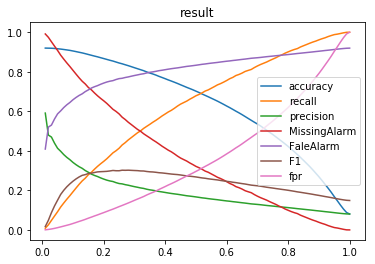

In [9]:
x_list = 1 - np.arange(0, 1, 0.01)
plt.title('result')
plt.plot(x_list, accuracy_list, label='accuracy')
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.plot(x_list, MissingAlarm_list, label='MissingAlarm')
plt.plot(x_list, FalseAlarm_list, label='FaleAlarm')
plt.plot(x_list, F1_list, label='F1')
plt.plot(x_list, fpr_list, label='fpr')
plt.legend()
plt.show()

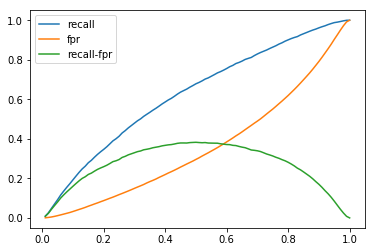

In [10]:
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, fpr_list, label='fpr')
plt.plot(x_list, [recall_list[i] - fpr_list[i] for i in range(len(recall_list))], label='recall-fpr')
plt.legend()
plt.show()

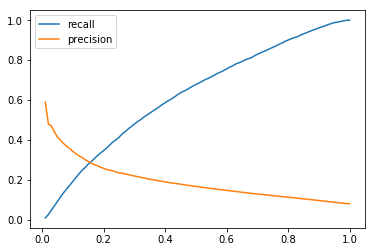

In [11]:
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.legend()
plt.show()

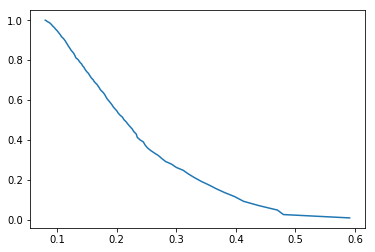

In [12]:
plt.plot(precision_list, recall_list, label='precision')
plt.show()

In [13]:
tpr_min_fpr = [recall_list[i] - fpr_list[i] for i in range(len(recall_list))]
ks = max(tpr_min_fpr)
ks

0.3825733205114992

In [14]:
X.columns

Index(['REGION_POPULATION_RELATIVE', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2',
       'pre_app_merged_installments_DAYS_INSTALMENT_min_mean',
       'bureau_merged_DAYS_CREDIT_max',
       'bureau_merged_DAYS_CREDIT_ENDDATE_max',
       'pre_app_merged_DAYS_FIRST_DRAWING_mean',
       'pre_app_merged_NAME_CONTRACT_TYPE_Consumer loans',
       'pre_app_merged_CNT_PAYMENT_max',
       'pre_app_merged_DAYS_FIRST_DRAWING_min', 'EXT_SOURCE_3',
       'pre_app_merged_installments_DAYS_INSTALMENT_max_std',
       'bureau_merged_DAYS_CREDIT_min',
       'pre_app_merged_NAME_CONTRACT_STATUS_Refused',
       'pre_app_merged_CNT_PAYMENT_std',
       'pre_app_merged_NAME_YIELD_GROUP_low_normal', 'DAYS_BIRTH',
       'pre_app_merged_NAME_YIELD_GROUP_XNA', 'DAYS_EMPLOYED',
       'pre_app_merged_PRODUCT_COMBINATION_Card Street', 'DAYS_REGISTRATION',
       'pre_app_merged_DAYS_LAST_DUE_mean',
       'pre_app_merged_NAME_CLIENT_TYPE_Refreshed',
       'pre_app_merged_RATE_DOWN_PAYMENT_max',
       'pre_app_

In [15]:
X.dtypes.value_counts()

float64    37
int64      12
dtype: int64

In [22]:
Y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [23]:
282686/24825

11.387150050352467